In [23]:
# Check the SBGC sites simulation for Umakant's sites
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import isamcalc_lib as isam
import C14preproc as prep
import pylab
import C14utils
import socplot_lib as socplt
import SOCtools as soc
import pandas as pd
import copy

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less_equal
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


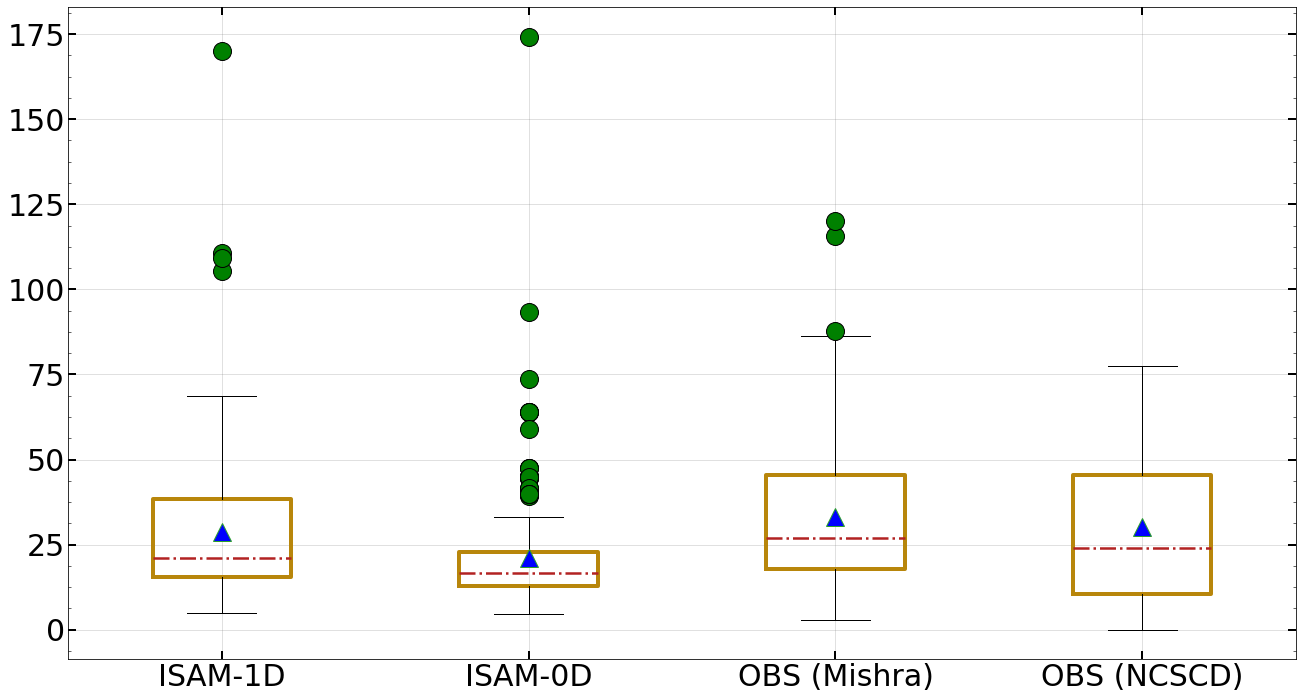

In [24]:
# =====================================================================
#  Plot the simulated SOC profiles for Umakant's samples
#  Compare with the observation also
# =====================================================================
fpath = "/data/jain1/c/sshu3/SBGC/data/C14/C14processing/"
fobs = "Mishra_soc_interp_197sites.csv"
fmod_pid = "caselist_197sites"
fmod_biome = "pftlist_197sites"
#fmod = "isam_um_soc_highdecomp.dat"
fmod = "isam_um_soc_newclim.dat"
#fmod = "isam_um_soc.dat"
fmod0 = "isam_0d_soc.dat"
fncscd = "NCSCD_extracted_197sites.csv"

# Read in obs
# 197 samples in total
obs = pd.read_csv(fpath+fobs, encoding='iso-8859-1', index_col=0)
# Read in the model output
mod = pd.read_csv(fpath+fmod, delim_whitespace=True, header=None)
#mod = pd.read_csv(fmod, header=None)
mod_pid = pd.read_csv(fpath+fmod_pid, header=None, index_col=0)
mod_biome = pd.read_csv(fpath+fmod_biome, header=None, index_col=0)
mod.index = mod_pid.index
# Read in the 0d model output
#mod0 = pd.read_csv(fmod0, delim_whitespace=True, header=None)
mod0 = pd.read_csv(fpath+fmod0, header=None)
mod0.index = mod_pid.index
# Read in the NCSCD data product!
ncscd_data = pd.read_csv(fpath+fncscd, index_col=0)

sel_profid = mod_pid.index
# Convert the interpolated SOC into ISAM depth
z, dz, zsoih = isam.get_isam_soildp(10)
# obs_as_isam = isam.mean_by_depth(10, zsoih, sel_profid.size, obs_sel.as_matrix())
obs_as_isam = isam.mean_by_depth_sep8(10, zsoih, sel_profid.size, obs.as_matrix())
obs_as_isam[obs_as_isam<=0]=float('nan')
# Unit convert: g/cm3 -> kg/m3
obs_isam = obs_as_isam * 1000.
obs_isam[obs_isam<0.] = float("nan")
# Aggregated SOC density to SOC stock profile till 1m
obs_agg_prof = soc.aggre_profden_to_profstock(10, dz, obs_isam)
# obs_agg = soc.aggre_profden_to_stock(7, dz, obs_isam)
obs_agg = soc.aggre_profden_to_stock_1m(zsoih, dz, obs_isam)

mod_isam = mod.as_matrix()/dz
mod_isam[mod_isam<0.] = float("nan")
mod_agg_prof = soc.aggre_profden_to_profstock(10, dz, mod_isam)
# mod_agg = soc.aggre_profden_to_stock(7, dz, mod_isam)
mod_agg = soc.aggre_profden_to_stock_1m(zsoih, dz, mod_isam)

# Filter out the observation if model did not calculate
# This may not be useful since all the results are available
obs_agg[np.isnan(mod_agg)] = float("nan")
obs_agg_prof[np.isnan(mod_agg_prof)] = float("nan")

mod0[mod0<0] = float("nan")
mod0_agg = mod0.as_matrix().reshape(197)

# Screen out NCSCD observations with the written
ncscd = ncscd_data.NCSCDv2_Ci.as_matrix()
ncscd[np.isnan(mod_agg)] = float("nan")

# Prepare figures
# 1) Barplot of the comparison of the total SOC stock 
# do not separate into different biomes (all in one)
obs_agg_avg = np.nanmean(obs_agg)
mod_agg_avg = np.nanmean(mod_agg)
mod0_avg = np.nanmean(mod0)
# Boxplot of the total SOC in the first 1m
# Shijie: Shall filter out peat before plotting!
data_for_bplot = [mod_agg[~np.isnan(mod_agg)], mod0_agg[~np.isnan(mod0_agg)], obs_agg[~np.isnan(obs_agg)], ncscd[~np.isnan(ncscd)]]

# multiple box plots on one figure
plt.figure(figsize=(22,12))
boxprops = dict(linestyle='-', linewidth=4, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=18,
                  linestyle='none')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
meanprops = dict(marker='^', markerfacecolor='blue', markersize=18,
                  linestyle='none')
#meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

plt.boxplot(data_for_bplot, boxprops=boxprops, flierprops=flierprops, \
           medianprops=medianprops, meanprops=meanprops, showmeans=True) #, meanlineprops=meanlineprops)
plt.xticks([1, 2, 3, 4], ['ISAM-1D', 'ISAM-0D', 'OBS (Mishra)', 'OBS (NCSCD)'], fontsize=30)
plt.yticks([0, 25, 50, 75, 100, 125, 150, 175], fontsize=30)
#plt.xlim((0, 9))
#plt.ylim((-500, 500))
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
plt.show()
#plt.savefig('./figures/fig5/fig5a.png')

In [ ]:
mod_agg

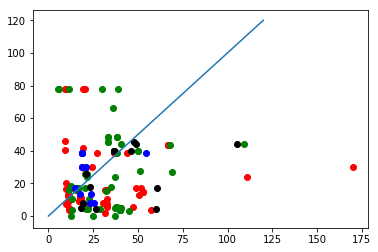

In [25]:
plt.scatter(mod_agg[mod_biome.index==5], ncscd[mod_biome.index==5], color='red')
plt.scatter(mod_agg[mod_biome.index==9], ncscd[mod_biome.index==9], color='green')
plt.scatter(mod_agg[mod_biome.index==20], ncscd[mod_biome.index==20], color='blue')
plt.scatter(mod_agg[mod_biome.index==8], ncscd[mod_biome.index==8], color='black')
plt.plot( [0,120],[0,120] )


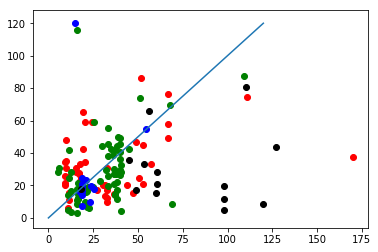

In [11]:
plt.scatter(mod_agg[mod_biome.index==5], obs_agg[mod_biome.index==5], color='red')
plt.scatter(mod_agg[mod_biome.index==9], obs_agg[mod_biome.index==9], color='green')
plt.scatter(mod_agg[mod_biome.index==20], obs_agg[mod_biome.index==20], color='blue')
plt.scatter(mod_agg[mod_biome.index==8], obs_agg[mod_biome.index==8], color='black')
plt.plot( [0,120],[0,120] )


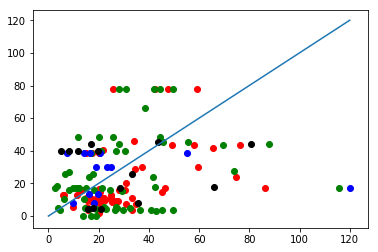

In [12]:
plt.scatter(obs_agg[mod_biome.index==5], ncscd[mod_biome.index==5], color='red')
plt.scatter(obs_agg[mod_biome.index==9], ncscd[mod_biome.index==9], color='green')
plt.scatter(obs_agg[mod_biome.index==20], ncscd[mod_biome.index==20], color='blue')
plt.scatter(obs_agg[mod_biome.index==8], ncscd[mod_biome.index==8], color='black')
plt.plot( [0,120],[0,120] )

In [3]:
# Now extract the corresponding data from the test cases 
fcontrol="Global_1DSBGC.bgc-yearly-3d_1920_control.nc"
fnodepmod="Global_1DSBGC.bgc-yearly-3d_26900_nodepthmod.nc"
fhighq10="Global_1DSBGC.bgc-yearly-3d_26900_highq10.nc"
fhighdecomp="Global_1DSBGC.bgc-yearly-3d_26900_highdecomp.nc"
fpath="/data/jain1/c/sshu3/SBGC/data/C14/C14processing/"

# Get Lon/Lat
lon=copy.deepcopy(ncscd_data.X.values)
lat=copy.deepcopy(ncscd_data.Y.values)

#for i in np.arange(len(lon)):
#    if(lon[i] > -1000 & lon[i] < 0):
#        lon[i]=180-lon[i]

idx=np.zeros((len(lon),2))
# Transfer lat/lon to index using halfdeg resolution
for i in np.arange(len(lon)):
    if(lon[i] < -1000):
        idx[i,:] = np.float('nan')
    else:
        idx[i,:] = isam.latlon_2_idx(lat[i],lon[i])
        idx[i,:] = idx[i,:] - 1

# Open the netcdf file of regional simulation
nclu=NetCDFFile(fpath+fcontrol,'r')
soclev_control = nclu.variables['soil_c_lev'][:]
latnc = nclu.variables['lat'][:]
lonnc = nclu.variables['lon'][:]
nclu.close()
nclu=NetCDFFile(fpath+fnodepmod,'r')
soclev_nodepmod = nclu.variables['soil_c_lev'][:]
nclu.close()
nclu=NetCDFFile(fpath+fhighdecomp,'r')
soclev_highdecomp = nclu.variables['soil_c_lev'][:]
nclu.close()
nclu=NetCDFFile(fpath+fhighq10,'r')
soclev_highq10 = nclu.variables['soil_c_lev'][:]
nclu.close()

# Cross evaluation of the results from the regional NCSCD dataset
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscd_masked_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
soc_ncscd = soc_ncscd_orig[0,:,:]
temp = copy.deepcopy(soc_ncscd[:,0:360])
soc_ncscd[:,0:360] = soc_ncscd[:,360:720]
soc_ncscd[:,360:720] = temp

nclu_obs.close()

# Extract the corresponding value from NC file
soc1m_control = soclev_control[0,:,:] + soclev_control[1,:,:] + soclev_control[2,:,:] + soclev_control[3,:,:] + soclev_control[4,:,:] + soclev_control[5,:,:] + soclev_control[6,:,:] + 0.3*soclev_control[7,:,:] 
soc1m_nodepmod = soclev_nodepmod[0,:,:] + soclev_nodepmod[1,:,:] + soclev_nodepmod[2,:,:] + soclev_nodepmod[3,:,:] + soclev_nodepmod[4,:,:] + soclev_nodepmod[5,:,:] + soclev_nodepmod[6,:,:] + 0.3*soclev_nodepmod[7,:,:]
soc1m_highdecomp = soclev_highdecomp[0,:,:] + soclev_highdecomp[1,:,:] + soclev_highdecomp[2,:,:] + soclev_highdecomp[3,:,:] + soclev_highdecomp[4,:,:] + soclev_highdecomp[5,:,:] + soclev_highdecomp[6,:,:] + 0.3*soclev_highdecomp[7,:,:]
soc1m_highq10 = soclev_highq10[0,:,:] + soclev_highq10[1,:,:] + soclev_highq10[2,:,:] + soclev_highq10[3,:,:] + soclev_highq10[4,:,:] + soclev_highq10[5,:,:] + soclev_highq10[6,:,:] + 0.3*soclev_highq10[7,:,:]

umsoc_control = np.zeros(len(lon))
umsoc_nodepmod = np.zeros(len(lon))
umsoc_highdecomp = np.zeros(len(lon))
umsoc_highq10 = np.zeros(len(lon))
umsoc_ncscd = np.zeros(len(lon))

for i in np.arange(len(lon)):
    if(np.isnan(idx[i,0])):
        umsoc_control[i] = np.float('nan')
        umsoc_nodepmod[i] = np.float('nan')
        umsoc_highdecomp[i] = np.float('nan')
        umsoc_highq10[i] = np.float('nan')
        umsoc_ncscd[i] = np.float('nan')
    else:
        umsoc_control[i] = soc1m_control[int(idx[i,0]), int(idx[i,1])]
        umsoc_nodepmod[i] = soc1m_nodepmod[int(idx[i,0]), int(idx[i,1])]
        umsoc_highdecomp[i] = soc1m_highdecomp[int(idx[i,0]), int(idx[i,1])]
        umsoc_highq10[i] = soc1m_highq10[int(idx[i,0]), int(idx[i,1])]
        umsoc_ncscd[i] = soc_ncscd[int(idx[i,0]), int(idx[i,1])]

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:74: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:75: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:76: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:77: UserWarning: Warning: converting a masked element to nan.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: UserWarning: Warning: converting a masked element to nan.


In [ ]:
ncscd

In [ ]:
plt.imshow(soc1m_control)

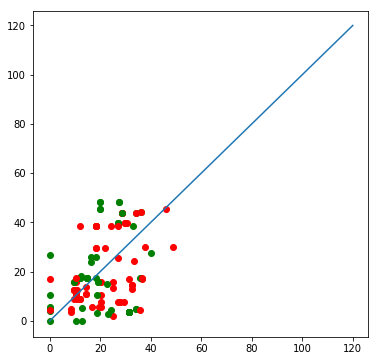

In [4]:
fig = plt.figure(figsize=(6,6))
plt.scatter(umsoc_control[mod_biome.index==5], ncscd[mod_biome.index==5], color='red')
plt.scatter(umsoc_control[mod_biome.index==9], ncscd[mod_biome.index==9], color='green')
plt.scatter(umsoc_control[mod_biome.index==20], ncscd[mod_biome.index==20], color='red')
plt.scatter(umsoc_control[mod_biome.index==8], ncscd[mod_biome.index==8], color='red')
plt.plot( [0,120],[0,120] )
#plt.savefig('um_scatter_control.png')

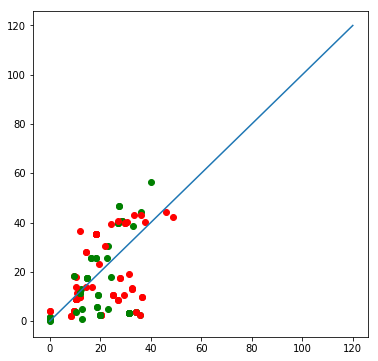

In [5]:
fig = plt.figure(figsize=(6,6))
plt.scatter(umsoc_control[mod_biome.index==5], umsoc_ncscd[mod_biome.index==5], color='red')
plt.scatter(umsoc_control[mod_biome.index==9], umsoc_ncscd[mod_biome.index==9], color='green')
plt.scatter(umsoc_control[mod_biome.index==20], umsoc_ncscd[mod_biome.index==20], color='red')
plt.scatter(umsoc_control[mod_biome.index==8], umsoc_ncscd[mod_biome.index==8], color='red')
plt.plot( [0,120],[0,120] )
#plt.savefig('um_scatter_nodepmod.png')

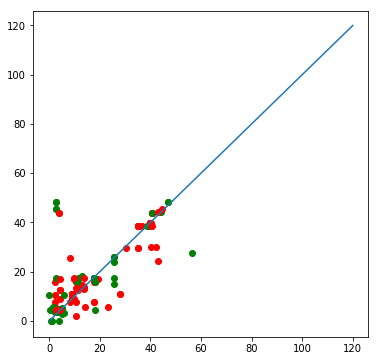

In [6]:
fig = plt.figure(figsize=(6,6))
plt.scatter(umsoc_ncscd[mod_biome.index==5], ncscd[mod_biome.index==5], color='red')
plt.scatter(umsoc_ncscd[mod_biome.index==9], ncscd[mod_biome.index==9], color='green')
plt.scatter(umsoc_ncscd[mod_biome.index==20], ncscd[mod_biome.index==20], color='red')
plt.scatter(umsoc_ncscd[mod_biome.index==8], ncscd[mod_biome.index==8], color='red')
plt.plot( [0,120],[0,120] )
#plt.savefig('um_scatter_highdecomp.png')

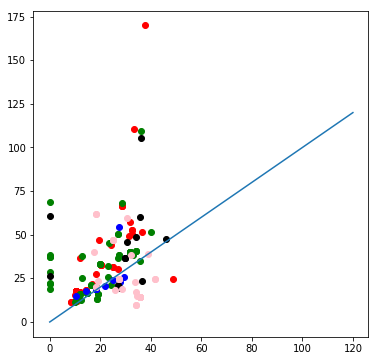

In [26]:
fig = plt.figure(figsize=(6,6))
plt.scatter(umsoc_control[mod_biome.index==5], mod_agg[mod_biome.index==5], color='red')
plt.scatter(umsoc_control[mod_biome.index==9], mod_agg[mod_biome.index==9], color='green')
plt.scatter(umsoc_control[mod_biome.index==20], mod_agg[mod_biome.index==20], color='blue')
plt.scatter(umsoc_control[mod_biome.index==8], mod_agg[mod_biome.index==8], color='black')
plt.scatter(umsoc_control[mod_biome.index==7], mod_agg[mod_biome.index==7], color='pink')
plt.plot( [0,120],[0,120] )
#plt.savefig('um_scatter_highq10.png')

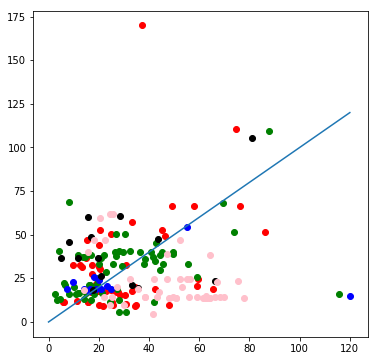

In [27]:
fig = plt.figure(figsize=(6,6))
plt.scatter(obs_agg[mod_biome.index==5], mod_agg[mod_biome.index==5], color='red')
plt.scatter(obs_agg[mod_biome.index==9], mod_agg[mod_biome.index==9], color='green')
plt.scatter(obs_agg[mod_biome.index==20], mod_agg[mod_biome.index==20], color='blue')
plt.scatter(obs_agg[mod_biome.index==8], mod_agg[mod_biome.index==8], color='black')
plt.scatter(obs_agg[mod_biome.index==7], mod_agg[mod_biome.index==7], color='pink')
plt.plot( [0,120],[0,120] )
#plt.savefig('um_scatter_highq10.png')

In [9]:
umsoc_control

array([29.94672613, 14.77617816, 14.77617816, 14.77617816, 14.77617816,
       14.4926415 , 12.1300812 , 12.26650807, 16.27000413, 12.1300812 ,
       16.27000413, 18.40624645, 22.90682085, 12.1300812 , 28.74562094,
       10.3759782 , 48.71810203, 10.23651431,         nan,         nan,
       35.67914027, 35.67914027, 36.00930519, 45.99931555, 33.40575958,
       17.4302533 , 30.50431081, 30.50431081, 29.94672613, 29.94672613,
       10.36023365, 10.36023365, 10.36023365, 10.36023365, 10.36023365,
       10.36023365, 32.47446114, 36.18977135, 27.74685879, 27.05717566,
       27.05717566, 37.84473653, 31.43281503, 36.60941825, 36.60941825,
       10.36023365, 12.09478093, 12.09478093, 24.11826798, 12.15006509,
       19.42849324, 10.36023365, 10.36023365, 14.32348397, 14.32348397,
       10.36023365, 10.74841146, 10.36023365, 25.77235312, 33.62513551,
       19.08986198, 33.96580141, 18.17648271, 28.74562094, 18.17648271,
       41.634522  , 41.634522  , 24.98564199, 32.34081563, 38.81

In [ ]:
umsoc_control>0

In [ ]:
np.nanmean*()

In [ ]:
# Double check climate data
fcontrol="Global_1DSBGC.bgp-yearly-3d_1920_control.nc"
fnodepmod="Global_1DSBGC.bgc-yearly-3d_26900_nodepthmod.nc"
fhighq10="Global_1DSBGC.bgc-yearly-3d_26900_highq10.nc"
fhighdecomp="Global_1DSBGC.bgc-yearly-3d_26900_highdecomp.nc"
fpath="/data/jain1/c/sshu3/SBGC/data/C14/C14processing/"


In [ ]:
int(360 + round((180 - 137.19) * 2 + 0.5))